In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.listdir('../content/')

['.config', 'drive', 'tem', 'sample_data']

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('../content/drive/My Drive/ParallelComputing/Dataset/Men-Women.zip','r')
zip_ref.extractall('tem')
zip_ref.close()

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import InputLayer
 
import tensorflow as tf
import random as rn
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
import keras.preprocessing.image as img
from keras.applications.resnet50 import ResNet50

In [ ]:
# Resizing the images into (256 * 256)
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
        except:
            pass
        
def assign_label(img,label):
    return label

In [ ]:
X=[]
Z=[]
IMG_SIZE=256
Men='../content/tem/traindata/traindata/men'
Women='../content/tem/traindata/traindata/women'

make_train_data('Men',Men)
make_train_data('Women',Women)

100%|██████████| 1912/1912 [00:33<00:00, 57.30it/s]


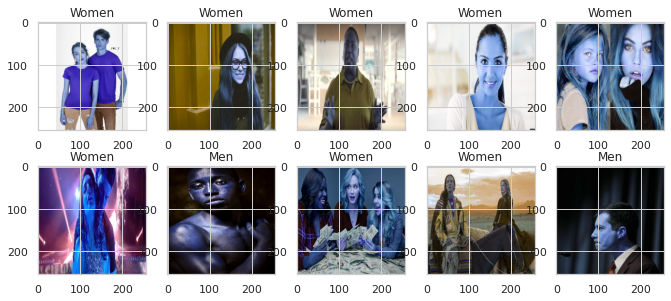

In [ ]:
# Displaying the training data with labels
fig,ax=plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(10,10)

for i in range(2):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l][:])
        ax[i,j].set_title(Z[l])
        ax[i,j].set_aspect('equal')

In [ ]:
# Splitting the data into Training and Validation data
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
print(Y)
X=np.array(X)

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=1337)

np.random.seed(42)
rn.seed(42)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# Building the CNN model using RESNET (pretrained model)
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(256,256,3), pooling='max')
base_model.summary()

94658560/94653016 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________

In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.20))
model.add(Dense(2048,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(512,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [ ]:
epochs=10
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=2, verbose=1)
base_model.trainable=True # setting the VGG model to be trainable.
model.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 30,408,066
Trainable params: 30,354,946
Non-trainable params: 53,120
_____________________________________

In [ ]:
History = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test,y_test))

Train on 2169 samples, validate on 724 samples
Epoch 1/10
2169/2169 [==============================] - 85s 39ms/step - loss: 0.8009 - accuracy: 0.7321 - val_loss: 0.3892 - val_accuracy: 0.8494
Epoch 2/10
2169/2169 [==============================] - 60s 27ms/step - loss: 0.3171 - accuracy: 0.8820 - val_loss: 0.3191 - val_accuracy: 0.8812
Epoch 3/10
2169/2169 [==============================] - 60s 28ms/step - loss: 0.2096 - accuracy: 0.9166 - val_loss: 0.3082 - val_accuracy: 0.8936
Epoch 4/10
2169/2169 [==============================] - 60s 28ms/step - loss: 0.1484 - accuracy: 0.9447 - val_loss: 0.3116 - val_accuracy: 0.8950
Epoch 5/10
2169/2169 [==============================] - 61s 28ms/step - loss: 0.1111 - accuracy: 0.9553 - val_loss: 0.3019 - val_accuracy: 0.9061
Epoch 6/10
2169/2169 [==============================] - 61s 28ms/step - loss: 0.0632 - accuracy: 0.9765 - val_loss: 0.3120 - val_accuracy: 0.8950
Epoch 7/10
2169/2169 [==============================] - 61s 28ms/step - loss:

In [ ]:
!mkdir -p saved_model
model.save('saved_model/KerasModelVer1')

In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

KerasModelVer1
ls: cannot access 'saved_model/my_model': No such file or directory


In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('saved_model/KerasModelVer1')

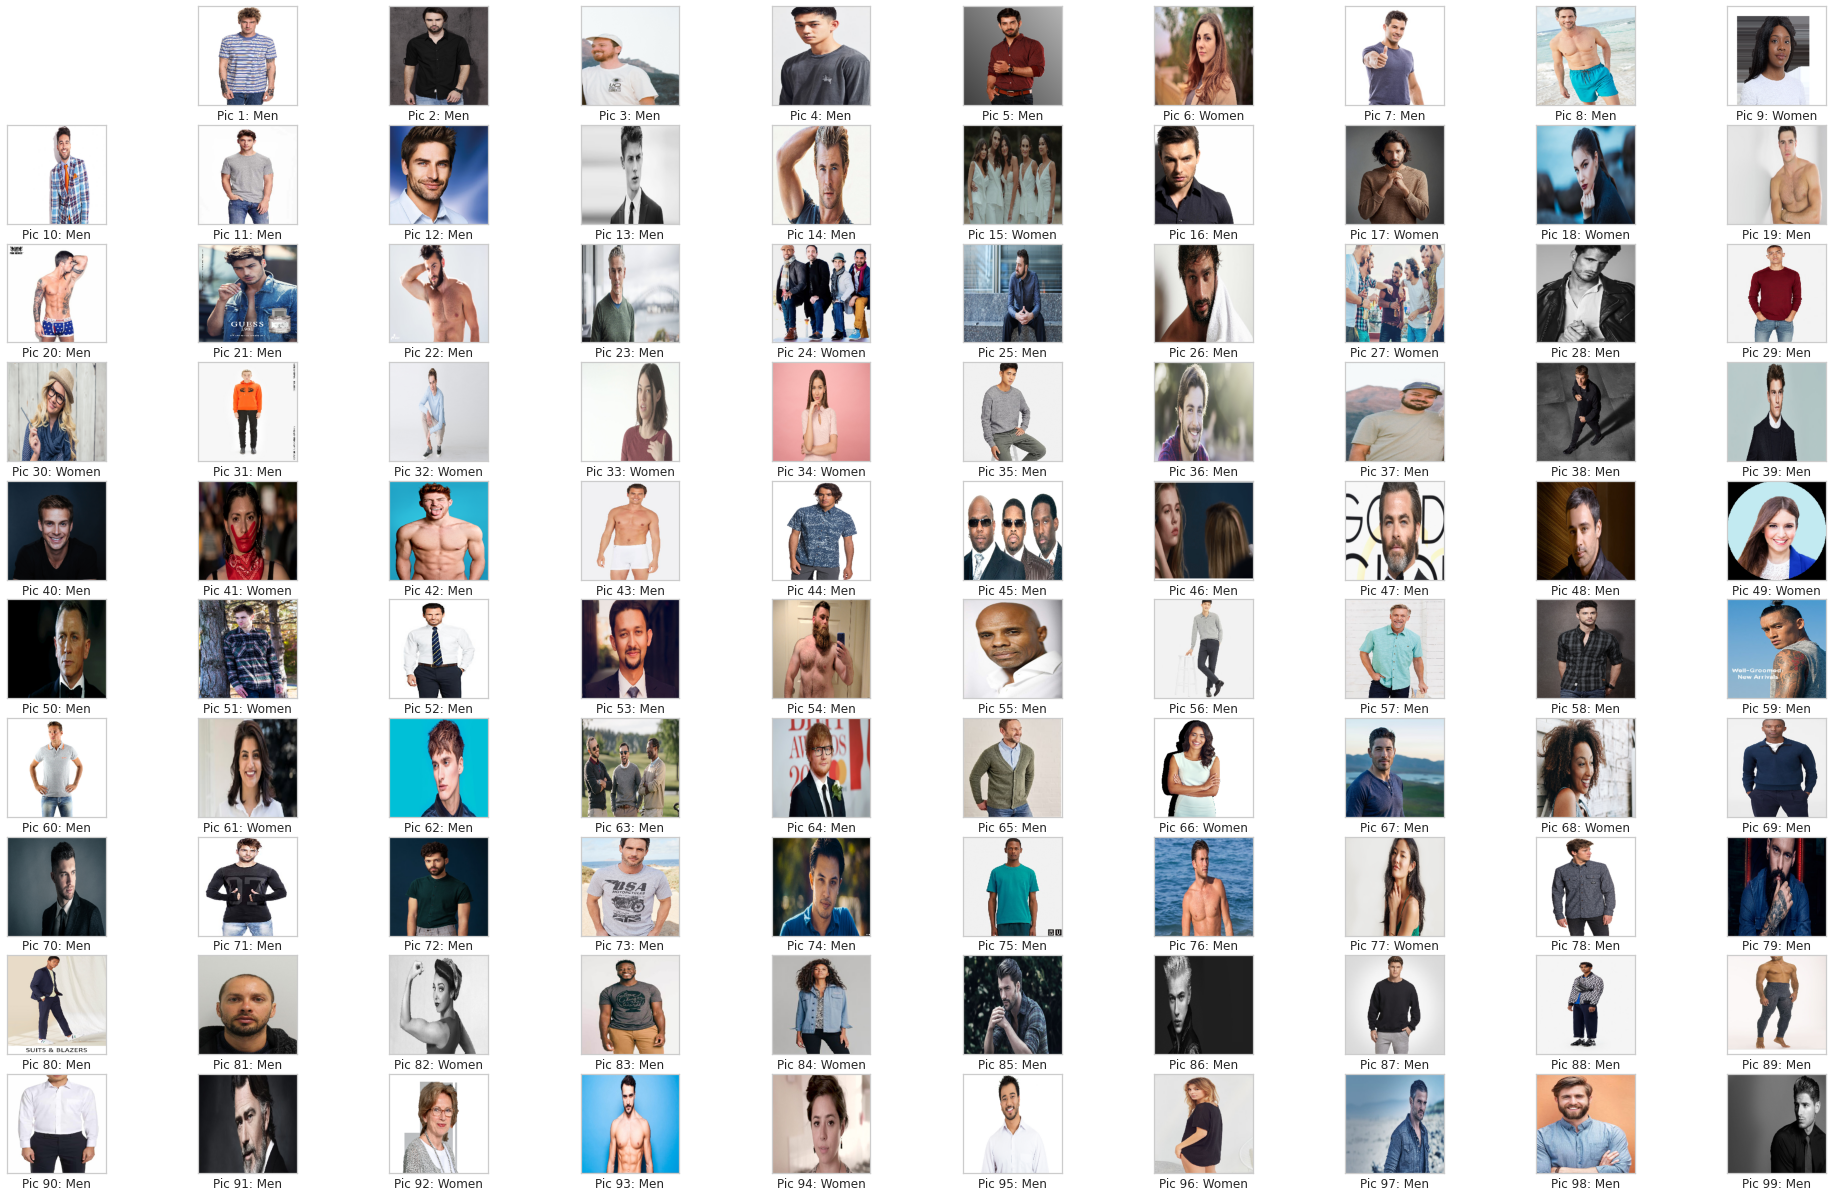

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing import image
import matplotlib.pyplot as plt
Dir='../content/tem/test/'
plt.figure(figsize=(30,20))
for i in range(1,100):
  plt.subplot(10,10,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  path='../content/tem/test/'+str(i)+'.jpg'
  img=image.load_img(path,target_size=(256,256))
  img= np.asarray(img)
  plt.imshow(img)
  img= np.expand_dims(img,axis=0)
  pred = np.round(model.predict(img))
  if pred[0][0] == 1:
      plt.xlabel('Pic '+ str(i) + ': Men')
  else:
    plt.xlabel('Pic '+ str(i) + ': Women')

In [ ]:
!pip3 install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
model_file = drive.CreateFile({"title" : "Keras Model Ver 1"})  # %s là tên file cần lưu
model_file.SetContentFile("%s")
model_file.Upload()

AttributeError: ignored